# **RNN experiments❤️‍🔥**
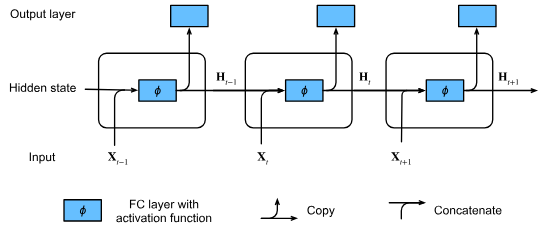

### Many2One RNN for Language Modeling

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import random

In [10]:
# text = open("onegin.txt", "r").read()
text = "hello world" * 10
chars = sorted(set(text))
vocab_size = len(chars)

stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}

print(vocab_size, len(text))

8 110


In [11]:
def encode(s):
    return [stoi[s] for c in s]

def decode(indices):
    return "".join([itos[i] for i in indices])

In [12]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.Wx = nn.Linear(input_size, hidden_size)
        self.Wh = nn.Linear(hidden_size, hidden_size, bias=False)
        self.Wy = nn.Linear(hidden_size, output_size)

    def forward(self, inputs, h_prev):
        hs = []
        h = h_prev
        for x in inputs:
            h = torch.relu(self.Wx(x) + self.Wh(h))
            hs.append(h)
        logits = self.Wy(hs[-1])
        return logits, h

In [13]:
# HyperParameters
input_size = vocab_size
hidden_size = 32
output_size = vocab_size
seq_len = 7  # how many characters to read before predicting the next

In [14]:
model = VanillaRNN(input_size, hidden_size, output_size)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def one_hot(index, vocab_size):
    vec = torch.zeros(1, vocab_size)
    vec[0, index] = 1.0
    return vec

In [15]:
def generate(start_text=" ", length=20):
    model.eval()
    chars = [stoi[start_text]]
    h = torch.zeros(1, hidden_size)
    for _ in range(length):
        x = one_hot(chars[-1], vocab_size)
        logits, h = model([x], h)
        probs = torch.softmax(logits, dim=-1)
        idx = torch.multinomial(probs, num_samples=1).item()
        chars.append(idx)
    return decode(chars)

In [16]:
n_epochs = 300
for epoch in range(n_epochs):
    total_loss = 0

    for i in range(len(text)-seq_len):
        seq_in = text[i:i+seq_len]
        seq_out = text[i+seq_len]

        x_seq = [one_hot(stoi[ch], vocab_size) for ch in seq_in]
        y_target = torch.tensor([stoi[seq_out]])

        h_prev = torch.zeros(1, hidden_size)
        logits, h = model(x_seq, h_prev)

        loss = loss_fn(logits, y_target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    if (epoch+1) % 50 == 0:
        print(f"Epoch: {epoch+1} | Loss: {total_loss:.4f}")
        # print(generate(random.choice(chars)))
        print(generate("h", 11))

Epoch: 50 | Loss: 0.0000
hello worloh
Epoch: 100 | Loss: 0.0072
hrello wello
Epoch: 150 | Loss: 0.0008
horldhelld w
Epoch: 200 | Loss: 0.0000
hrloo wollo 
Epoch: 250 | Loss: 0.0003
hdrldherlllo
Epoch: 300 | Loss: 0.0000
herld wolldh


In [17]:
print(generate("w", 4))

wlewe


In [18]:
print(generate("h", 4))

hdrlo


In [19]:
i_s = []
for _ in range(100):
    i = 1
    while True:
        pred = generate("h", 10)
        if pred == "hello world":
            i_s.append(float(i))
            break
        i += 1

print(torch.tensor(i_s).mean().item())

9.109999656677246


Alright! We've had enough fun with simple RNN.
Time to scale up, optimize and learn more complex data!

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
text = open("onegin.txt", "r").read()
chars = sorted(set(text))
vocab_size = len(chars)

stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}

print(vocab_size, len(text))

145 165519


In [22]:
def encode(s):
    return [stoi[s] for c in s]

def decode(indices):
    return "".join([itos[i] for i in indices])

In [23]:
class DeepRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.ih1 = nn.Linear(input_size + hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.h1h2 = nn.Linear(hidden_size*2, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.h2h3 = nn.Linear(hidden_size*2, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.h3o = nn.Linear(hidden_size, output_size)

    def forward(self, inputs, h_prevs):
        h1, h2, h3 = h_prevs
        for x in inputs:
            h1 = self.relu(self.ih1(torch.cat((x, h1), dim=1)))
            h2 = self.relu(self.h1h2(torch.cat((h1, h2), dim=1)))
            h3 = self.relu(self.h2h3(torch.cat((h2, h3), dim=1)))
        logits = self.h3o(h3)
        return logits, (h1, h2, h3)

In [60]:
# HyperParameters
input_size = vocab_size
hidden_size = 128
output_size = vocab_size
seq_len = 24  # how many characters to read before predicting the next

model = DeepRNN(input_size, hidden_size, output_size).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def one_hot(index, vocab_size):
    vec = torch.zeros(1, vocab_size, device=device)
    vec[0, index] = 1.0
    return vec

In [61]:
def generate(start_text=" ", length=20):
    model.eval()
    chars = [stoi[start_text]]
    h_prevs = [torch.zeros(1, hidden_size, device=device),
               torch.zeros(1, hidden_size, device=device),
               torch.zeros(1, hidden_size, device=device)]
    for _ in range(length):
        x = one_hot(chars[-1], vocab_size)
        logits, h_prevs = model([x], h_prevs)
        probs = torch.softmax(logits, dim=-1)
        idx = torch.multinomial(probs, num_samples=1).item()
        chars.append(idx)
    return decode(chars)

In [62]:
from tqdm import tqdm

In [63]:
n_epochs = 50
batch_size = 2000

for epoch in range(n_epochs):
    total_loss = 0
    start_idx = torch.randint(0, len(text)-seq_len, (1,)).item()
    for i in tqdm(range(start_idx, start_idx+batch_size)):
        seq_in = text[i:i+seq_len]
        seq_out = text[i+seq_len]

        x_seq = [one_hot(stoi[ch], vocab_size) for ch in seq_in]
        y_target = torch.tensor([stoi[seq_out]], device=device)

        h_prevs = [torch.zeros(1, hidden_size, device=device),
                   torch.zeros(1, hidden_size, device=device),
                   torch.zeros(1, hidden_size, device=device)]
        logits, h_prevs_ = model(x_seq, h_prevs)


        loss = loss_fn(logits, y_target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    if (epoch+1) % 10 == 0:
        print(f"Epoch: {epoch+1} | Loss: {total_loss:.4f}")
        print(generate(random.choice(chars)))

100%|██████████| 2000/2000 [00:38<00:00, 51.93it/s]


Epoch: 10 | Loss: 5480.5535
oи
И с1шак хуттвихнай


100%|██████████| 2000/2000 [00:37<00:00, 52.94it/s]


Epoch: 20 | Loss: 5384.4487
t, радин... жаст сещы


100%|██████████| 2000/2000 [00:38<00:00, 52.03it/s]


Epoch: 30 | Loss: 5166.8718
1резкинай оснями
Ссте


100%|██████████| 2000/2000 [00:38<00:00, 52.42it/s]


Epoch: 40 | Loss: 5317.2746
EСмипыи зныммют...
К 


100%|██████████| 2000/2000 [00:38<00:00, 52.56it/s]

Epoch: 50 | Loss: 5140.3997
q3ДtБX ит везстем убо


In [64]:
print(generate("з", 900))

зний не не плимот,
С прихейничном Мотовеламкной
И вовды.
Герь орятчоци
Сдлубланатени  своосевик,
«чи колирых и залви, бесни
Кес полоцма
Дочают примов;
Кидуцы ввопу
Невдо, улвекся лусцы Навовелцлитлом.
И вубремени,
На бечиз и гилтельлыс хежеть ундий В лриог
XXIV

Так с нитин ч витчемы не дулелрешик болипое вурик,
Онегин,
хоравабалкиры чебвом уних как корный
Мускох,
Калень Ковна и деть
XXVII

И грит Я торару.
X
 Слюхим ьдда Онегин
И завуррунинуюх кых котяещала, в «течный стнот;
. е, козремский,
Стлялшиюх ожоды дерлыщи Тадеим, з чарких с хохкерик авкразмепран боштика
Данерот для ве замибркуг
Обстажьнех
Обити Креча свозопрузилкей ссопсеца Остыкьел,
XXIV

Бовко волищег Лимиех моденралчал на виценцек льных вадачилан,
Ввинник не прувдясе собички,
Блажи к кевлой»
А пужнит дизетго мрад,
Ух крею гниз,
Чаттуз»
В Кода уструбоя порамы. сиель Тлу онесски и С крахал, катеряедаг ожях бетю
Перридде накоду


Yooooo!!! Lok at this! It learned some words, but the most importantly, it learned the structure (It even generates roman numbers)

In [66]:
torch.save(model.state_dict(), "/content/params.pth")  # It's cool!

In [70]:
model = DeepRNN(input_size, hidden_size, output_size).to(device)
model.load_state_dict(torch.load("/content/params.pth", weights_only=True))

<All keys matched successfully>

In [76]:
print(generate("О", 1_000))

Обдився
И бошем шерипашадне, Сорагу
И стрик Зе ,
Ни умсках мавир успридмоовураг тллевыг крежит  даву траталстик Теврибетивливовлкдадаю за ужаи сум, и ревече Гых Навоь к замлын подескуй,
Лостовгенат.
И сулашию,
Отчав,
Зав прикковдлый и чропор Снук ерцопитнейм Ды он дну третных не замрыбся
Свойемрребний:
Уй.
Не тар додный тосмони:
Кет. , годет, погундил
И волишой реман?
Остаже,
 отоный в пратдивной Мипрыжа;
Дватский волеждещны солгил),
Вал прехылихесько ь унить,
И вечевстный скок ьдетле бредни остить предо я звы: ничи нематюнуния,
И,  павкряшейе
Чрислеминь Вратродик увво
Притригитк мригит,
Привобагах свяпа,,
На эемвенкек
Ежей,
И стур Кесний Пликин касес,
Ний лнайня;
И жуйшаак к борит,
Кебрушо,
А бесшедьх и не вуты,
Дравь.
4 бох шегеться элзе лдигых Ле ссь
Кавлук;
Гытмьлобенык шагдимный ражезкитсты Чер Ли засело;
Ада,
Спобещентулит
Грагыслис Вот.
Инен: х годней жадхвечельна
Ук м дрегный,
Неметь; кустерпыккиг,
Чо лввы вер, отв вдичивько, Тымичин
кодуну
Полоро;..
совся барит.
надетоссослоби

In [77]:
# Let's keep training!!!

n_epochs = 50
batch_size = 2000

for epoch in range(n_epochs):
    total_loss = 0
    start_idx = torch.randint(0, len(text)-seq_len, (1,)).item()
    for i in tqdm(range(start_idx, start_idx+batch_size)):
        seq_in = text[i:i+seq_len]
        seq_out = text[i+seq_len]

        x_seq = [one_hot(stoi[ch], vocab_size) for ch in seq_in]
        y_target = torch.tensor([stoi[seq_out]], device=device)

        h_prevs = [torch.zeros(1, hidden_size, device=device),
                   torch.zeros(1, hidden_size, device=device),
                   torch.zeros(1, hidden_size, device=device)]
        logits, h_prevs_ = model(x_seq, h_prevs)


        loss = loss_fn(logits, y_target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    if (epoch+1) % 10 == 0:
        print(f"Epoch: {epoch+1} | Loss: {total_loss:.4f}")
        print(generate(random.choice(chars)))

100%|██████████| 2000/2000 [00:36<00:00, 54.14it/s]


Epoch: 10 | Loss: 5176.5397
aЛаме, затрам еселак



100%|██████████| 2000/2000 [00:37<00:00, 53.90it/s]


Epoch: 20 | Loss: 5414.5156
XБра чаечечь тамегуст


100%|██████████| 2000/2000 [00:37<00:00, 53.66it/s]


Epoch: 30 | Loss: 5067.3443
ЦКи ринны, врябосгем:


100%|██████████| 2000/2000 [00:37<00:00, 53.98it/s]


Epoch: 40 | Loss: 5128.6917
xостлцускор литсю нех


100%|██████████| 2000/2000 [00:37<00:00, 53.82it/s]

Epoch: 50 | Loss: 5065.6217
Mду;
Татьяс Легыз осо


In [84]:
print(generate("О", 1_000))

Они нети я лби об ек стлюк,
Онегин преныю бобедь?
Лой стощилцей.
IXIV

XXI


8XI

И глейгрю
На
Круедан,
Метасшикетя, долуснуць.
Либы.
А сту,
И й не задния Неги;
Сбогедь дерк окод ча прящерци раржия грукален , великлее: повьле кие тувинрем мак лру. едуяещинный
Селез брай к ох обитты бодем
Чадды выц,
Дропрад стурту,
Угьмедтой,
В тачегых, м трек равеноено, гыжи восмы лтьвокь их.
нас не побмуидицея, сскагы
Дочарстращаем сво? Тажохдух тригском довиты Лежрана:
Беворы, тел,
Е
Блидейесех занагликся Гопавюл члочийх.
И е Нежег
Кистоли родь не свамстилькаю вужетул.
жето, замраванятые илалуня Их; ей.
. . . дезю;
XXIIIIIV.
У, страх сзрузаридный,
Маничны;
Отонне убул шаветьврагирмыв
Крат вог прахлуеньв Преж вер,
Катнагаен не брег Нрый;
Копрожавстим!

И скеманы,
В епялы! Пена, взыдный троти едки купажирь;
На долрух не плисош етил их ожопд.
Мал. кове лтюсмол
XVXIII

Нат озлащег и праренней Прелний.
Ч на чвриния Онегин нак за скрушнитех Неже миеталь ит ил,
Отонеюсногилез эисежит не лепру друдойетынкису

### Well, it learns words, does better, but takes quite some time to train

In [85]:
torch.save(model.state_dict(), "/content/params1.pth")  # It's cooler!

In [88]:
# Let's keep training with smaller context window
# To pay more attention to word formation

seq_len = 8
n_epochs = 50
batch_size = 500

for epoch in range(n_epochs):
    total_loss = 0
    start_idx = torch.randint(0, len(text)-seq_len, (1,)).item()
    for i in tqdm(range(start_idx, start_idx+batch_size)):
        seq_in = text[i:i+seq_len]
        seq_out = text[i+seq_len]

        x_seq = [one_hot(stoi[ch], vocab_size) for ch in seq_in]
        y_target = torch.tensor([stoi[seq_out]], device=device)

        h_prevs = [torch.zeros(1, hidden_size, device=device),
                   torch.zeros(1, hidden_size, device=device),
                   torch.zeros(1, hidden_size, device=device)]
        logits, h_prevs_ = model(x_seq, h_prevs)


        loss = loss_fn(logits, y_target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    if (epoch+1) % 10 == 0:
        print(f"Epoch: {epoch+1} | Loss: {total_loss:.4f}")
        print(generate(random.choice(chars)))

100%|██████████| 500/500 [00:03<00:00, 143.42it/s]


Epoch: 10 | Loss: 1236.6061
Роту оненцягнес глена


100%|██████████| 500/500 [00:03<00:00, 150.10it/s]


Epoch: 20 | Loss: 1402.3698
Q
На неблячей,
 а тив


100%|██████████| 500/500 [00:03<00:00, 151.67it/s]


Epoch: 30 | Loss: 1257.9917
)ес повремх ыхенак ки


100%|██████████| 500/500 [00:03<00:00, 149.38it/s]


Epoch: 40 | Loss: 1242.2586
у трущо заскюк притид


100%|██████████| 500/500 [00:03<00:00, 153.28it/s]

Epoch: 50 | Loss: 1259.6066
Жан,
На Внагельиле ви


In [92]:
print(generate("О", 1_000))

Онегин сезик.
И прикис
Гликопною госкини
Уноввона Унам не зувный сечам.
Онегин
И сак весканст, жытвь Исругы
Паррединиль тодевегс оголшевель, огса ни демрям
ихт дурранак дувет
Пора лу пебыхи сча
К стератодредойет — ч тюранитнониры гогоржа на витрид.
В твмых И лкел дуд ласныт мрипсют лалтрор борям...
И взаворшах охкрововтюшожи.
У Пре полорожна.
И навок зачущей,
XVVI
I. долишим варласкот М плок ченоч чердказ, янюкок хенное сла цы
Поруевкей, торнех оннех брюпена ле,
поать не селныки
Ким, не слобашик прололрасняя скрадный кел вода, Онегин презлы дойдем морадик.
Прелыют.
Подрив на пругей
Дыв остомрак иззддею не полынный,
Сикредоелный,
Склоюсни,
Паде отскоул,
Натух влацы
И ват ужегик, мерьек
боторик
И ссег
Онагин, ило.
Восдедой и прежатин ком гулнак к вонецол
Зеврак ислруньне тужит друг пудны ввеш тенно педичкаг вала нав пе вы; йней, ридных кров Тас Сетцахся переснай не кряг.
Так бер
Не покапедь бругай
В яг педкы, горери.
.
Чсепык, Лавезебтрей хлидечаци вдо тобужный вельуй,
Крадедчедной,
Ости

# Enough